In [34]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import glob

#Utility Functions
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
  max_dim = 1000
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

#Gram Matrix Function
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

#ML Functions
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

#Model Class
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

#Loss function
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

#Create callable training step function
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [35]:
def resize_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  new_shape = tf.cast(shape + 1, tf.int32)
  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
resize_images = sorted(glob.glob("/content/stylized_*.png"))
k = 0
for f in resize_images:
  image = resize_img(f)
  filename = "resized" + "_" + str(k) + ".png"
  tensor_to_image(image).save(filename)
  k = k + 1

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


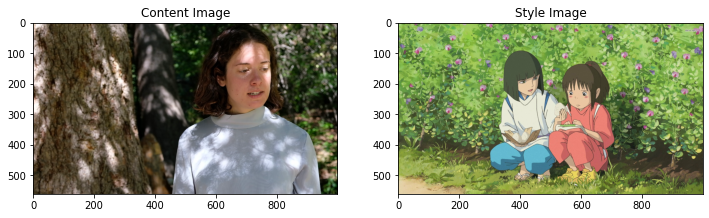

In [6]:
style_image = load_img("/content/drive/MyDrive/MarigoldLocal/imgs/style/chihiro-spirited-away.jpg")
content_image = load_img("/content/drive/MyDrive/MarigoldLocal/imgs/DSCF3843.MOV0001.png")

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [31]:
#Select layers (modify for experimentation)
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [32]:
#extractor = StyleContentModel(style_layers, content_layers)
extractor = StyleContentModel(style_layers, content_layers)
#Set style and content targets for gradient descent
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

#Image Variable To Be Optimized
image = tf.Variable(content_image)

#Choose optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

#Set style and content weights for the loss function
style_weight=1e-2
content_weight=1e2

#High frequency adjustment for loss function
total_variation_weight=30

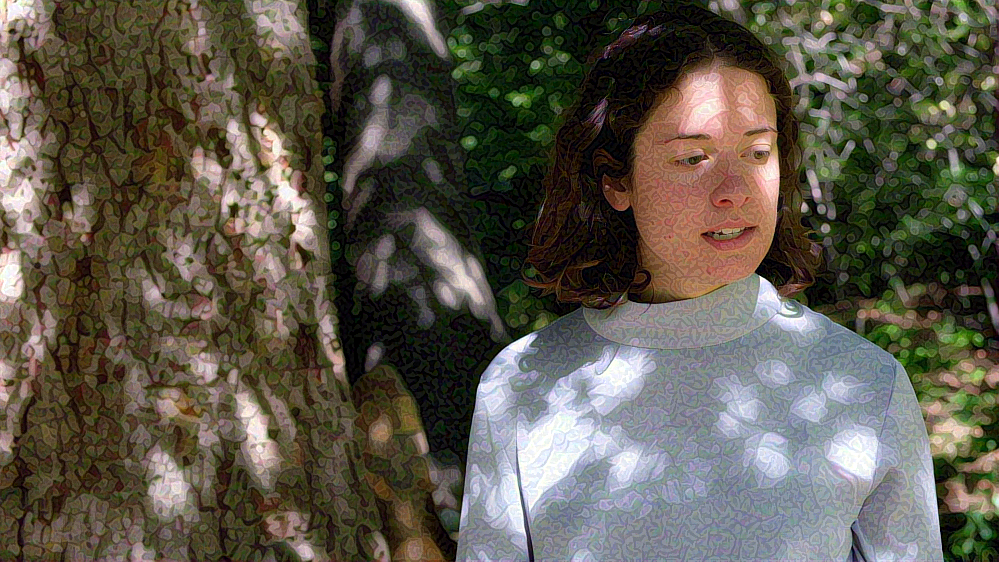

In [12]:
#Test training steps if modifying anything above
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

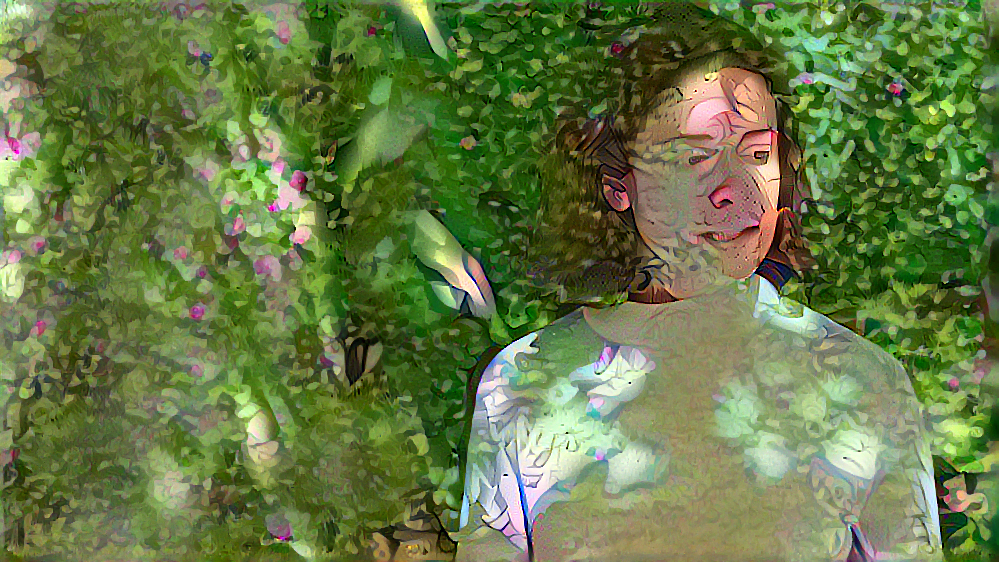

Train step: 300
............................................................................................

KeyboardInterrupt: ignored

In [33]:
#Run training steps
import time
start = time.time()

epochs = 5
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

#Save image
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

In [ ]:
j = 0
print("image" + str(j) + " completed")

image0 completed


In [ ]:
#Try for a whole video
content_images = sorted(glob.glob("/content/drive/MyDrive/MarigoldLocal/imgs/*.png"))
import time
i=0

extractor = StyleContentModel(style_layers, content_layers)
for f in content_images:
  content_image = load_img(f)
  image = tf.Variable(content_image)

  #Run training steps
  epochs = 10
  steps_per_epoch = 100
  step = 0

  for n in range(epochs):
    for m in range(steps_per_epoch):
      #step += 1
      train_step(image)
      #print(".", end='')
  filename = "stylized" + "_" + str(i) + ".png"
  tensor_to_image(image).save(filename)
  i = i+1

In [ ]:
!zip -r /content/file.zip /content/resized*.png